# STAT3612 Group Project

The theme of this semester is interpretable machine learning (IML) with applications to a real datacase study.

For an IML model, both **prediction accuracy and model explainability are equally important**. 
You will need to take both objectives into account when building models in this project.

The data includes about 10,400 anonymized Home Equity Line of Credit (HELOC) loans,together with 23 attributes. 

Note that in the second Excel file the monotonicity constraints are included in the data dictionary, which are based on the prior knowledge about the feature-target effect. 

**Build your IML models based only on the training data**.  
There is no restriction in the choice of feature engineering techniques or machine learning algorithms. 

The final model evaluations will be based on three aspects:
1.  Prediction accuracy as tested on the remaining 20% dataset
2.  Global interpretability about the model effects
3.  Local interpretability about individual predictions (Good/Bad cases from testing data).

## Importing Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from tabulate import tabulate # printing output as tables

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Reading datasets

In [36]:
pd.set_option('display.max_colwidth', -1) # show complete variable names
heloc = pd.read_csv('HelocData.csv')
dataDict = pd.read_excel('HelocDataDict2.xlsx')
dataDict['Description'] = dataDict['Description'].apply(
    lambda x: x.split('.')[0] if '.' in x else x)[1:] # Only extract the first sentence

In [37]:
dataDict

,Variable Names,Description,Monotonicity Constraint w.r.t. Prob(Bad = 1)
0,RiskFlag,NaN,NaN
1,x1,Consolidated version of risk markers,Monotonically Decreasing
2,x2,Months Since Oldest Trade Open,Monotonically Decreasing
3,x3,Months Since Most Recent Trade Open,Monotonically Decreasing
4,x4,Average Months in File,Monotonically Decreasing
5,x5,Number Satisfactory Trades,Monotonically Decreasing
6,x6,Number Trades 60+ Ever,Monotonically Increasing
7,x7,Number Trades 90+ Ever,Monotonically Increasing
8,x8,Percent Trades Never Delinquent,Monotonically Decreasing
9,x9,Months Since Most Recent Delinquency,Monotonically Decreasing


In [38]:
# impute the missing values with the mean of each column 
features = heloc.columns.tolist()[1:] # list of x_i 
heloc[features] = heloc[features][heloc[features] >= 0].fillna(heloc[features].mean())

In [39]:
heloc.head()

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,Bad,75.0,169.0,2.0,59.0,21.0,0.0,0.0,100.0,6.762406,...,36.0,-0.325366,4.0,4.0,43.0,112.000000,4.0,6.0,0.0,83.0
1,Bad,66.0,502.0,4.0,145.0,34.0,0.0,0.0,97.0,36.000000,...,27.0,4.000000,3.0,3.0,80.0,53.000000,17.0,3.0,12.0,83.0
2,Good,69.0,338.0,2.0,62.0,22.0,0.0,0.0,96.0,12.000000,...,35.0,0.000000,4.0,4.0,25.0,100.000000,3.0,2.0,1.0,45.0
3,Good,75.0,422.0,1.0,91.0,55.0,0.0,0.0,100.0,6.762406,...,33.0,0.000000,4.0,4.0,2.0,11.000000,12.0,2.0,1.0,57.0
4,Bad,63.0,242.0,2.0,68.0,25.0,0.0,0.0,100.0,6.762406,...,19.0,-0.325366,3.0,3.0,73.0,39.158906,12.0,1.0,5.0,87.0


In [40]:
GID = 20190006 # group Id
np.random.seed(GID) # set GID as random seed

# create binary 0/1 'good/bad' variable in dataframe
scaler = StandardScaler()
y = heloc['RiskFlag'].map({'Good':0, 'Bad':1})
X = heloc.drop('RiskFlag', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=GID) # 80/20 train/test split

preprocessing finished

---

## EDA and feature engineering

In [41]:
''' 
fig = plt.figure(figsize=(15,20))
for i in range(1,len(x_cols)+1):
    plt.subplot(6,4,i)
    sns.boxplot( X_train[x_cols[i-1]], heloc.RiskFlag, )
plt.tight_layout()
plt.show()
'''

' \nfig = plt.figure(figsize=(15,20))\nfor i in range(1,len(x_cols)+1):\n    plt.subplot(6,4,i)\n    sns.boxplot( X_train[x_cols[i-1]], heloc.RiskFlag, )\nplt.tight_layout()\nplt.show()\n'

**NOTE**
10. Max Delq/Public Records Last 12 Months: Values 0-7 are monotonically decreasing (step function)
11. Max Delinquency Ever: Values 2-8 are monotonically decreasing (step function)

In [42]:
# we dont want to include x9 since over half of its features are 'missing'
# Use the monotonicity constraints in our preprocessing

In [43]:
dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Decreasing']

,Variable Names,Description,Monotonicity Constraint w.r.t. Prob(Bad = 1)
1,x1,Consolidated version of risk markers,Monotonically Decreasing
2,x2,Months Since Oldest Trade Open,Monotonically Decreasing
3,x3,Months Since Most Recent Trade Open,Monotonically Decreasing
4,x4,Average Months in File,Monotonically Decreasing
5,x5,Number Satisfactory Trades,Monotonically Decreasing
8,x8,Percent Trades Never Delinquent,Monotonically Decreasing
9,x9,Months Since Most Recent Delinquency,Monotonically Decreasing
15,x15,Months Since Most Recent Inq excl 7days,Monotonically Decreasing


In [44]:
dataDict[dataDict['Monotonicity Constraint w.r.t. Prob(Bad = 1)'] == 'Monotonically Increasing']

,Variable Names,Description,Monotonicity Constraint w.r.t. Prob(Bad = 1)
6,x6,Number Trades 60+ Ever,Monotonically Increasing
7,x7,Number Trades 90+ Ever,Monotonically Increasing
13,x13,Number of Trades Open in Last 12 Months,Monotonically Increasing
16,x16,Number of Inq Last 6 Months,Monotonically Increasing
17,x17,Number of Inq Last 6 Months excl 7days,Monotonically Increasing
18,x18,Net Fraction Revolving Burden,Monotonically Increasing
19,x19,Net Fraction Installment Burden,Monotonically Increasing
22,x22,Number Bank/Natl Trades w high utilization ratio,Monotonically Increasing


In [ ]:
# Compare Algorithms

models = [('LR', LogisticRegression(solver='newton-cg',C=1e6)), 
          ('CART', DecisionTreeClassifier()), 
          ('SVM', SVC(gamma='scale', kernel='rbf')), 
          ('XGB', XGBClassifier())
         ]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
   

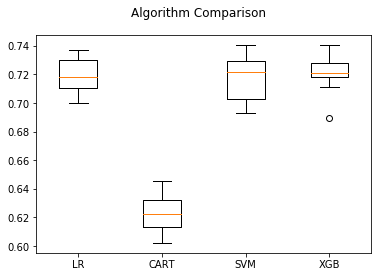

In [71]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the analysis above, logistic regression performs as well as the two black box models, support vector machines and gradient boosted trees.

Logisitic regression gives us a natural way of interpreting the model output- 'probabilities' of repaying a loan.  

---

## Model Building

In [45]:
from pygam import LogisticGAM #increased flexibility on our models features.

## Hyperparameter tuning

In [49]:
lr = LogisticRegression()
param_grid = dict(penalty = ['l1', 'l2'], C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)

# grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

NameError: name 'grid_result' is not defined

## Model Evaluation

In [ ]:
# we will calculate train and test error rates for all models
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

In [ ]:
def accuracy(model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    acc_train = accuracy_score(y_train,y_train_pred)
    acc_test = accuracy_score(y_test,y_test_pred)

    print('The Acc on training set:',acc_train)
    print('The Acc on testing set:',acc_test)

In [ ]:
def roc_auc(model):
    return